In [1]:
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib
import matplotlib.pylab as plt

from torchvision.utils import make_grid, save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
batch_size = 512
epochs = 200
sample_size = 64
nz = 128
k = 1

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_dataset = datasets.MNIST(
    root="../chap13/data", train=True, transform=transform, download=True)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [7]:
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

losses_g = []
losses_d = []
images = []

In [8]:
def save_generator_image(image, path):
    save_image(image, path)

In [9]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    fake_label = torch.zeros(b_size, 1).to(device)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [10]:
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [12]:
generator.train()
discriminator.train()

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for idx, data in tqdm(enumerate(train_loader), total=int(len(train_dataset)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        for step in range(k):
            data_fake = generator(torch.randn(b_size, nz).to(device)).detach()
            data_real = image
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(torch.randn(b_size, nz).to(device))
        loss_g += train_generator(optim_g, data_fake)
    generated_img = generator(torch.randn(b_size, nz).to(device)).cpu().detach()
    generated_img = make_grid(generated_img)
    save_generator_image(generated_img, f"../chap13/img/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / idx
    epoch_loss_d = loss_d / idx
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch} of {epochs}")
    print(
        f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

118it [00:00, 223.04it/s]                         

Epoch 0 of 200
Generator loss: 1.74141371, Discriminator loss: 1.35503268



118it [00:00, 207.60it/s]                         

Epoch 1 of 200
Generator loss: 6.22437286, Discriminator loss: 0.36273840



118it [00:00, 216.55it/s]                         

Epoch 2 of 200
Generator loss: 3.28985262, Discriminator loss: 0.83356929



118it [00:00, 219.45it/s]                         

Epoch 3 of 200
Generator loss: 3.82398486, Discriminator loss: 0.72763729



118it [00:00, 208.91it/s]                         

Epoch 4 of 200
Generator loss: 1.95831347, Discriminator loss: 1.06812000



118it [00:00, 224.22it/s]                         

Epoch 5 of 200
Generator loss: 2.35707855, Discriminator loss: 0.91170228



118it [00:00, 222.04it/s]                         

Epoch 6 of 200
Generator loss: 2.70775986, Discriminator loss: 0.91538161



118it [00:00, 218.10it/s]                         

Epoch 7 of 200
Generator loss: 1.56902361, Discriminator loss: 1.15167034



118it [00:00, 205.15it/s]                         

Epoch 8 of 200
Generator loss: 1.60336113, Discriminator loss: 1.09849036



118it [00:00, 221.45it/s]                         

Epoch 9 of 200
Generator loss: 1.29728353, Discriminator loss: 1.10731184



118it [00:00, 208.16it/s]                         

Epoch 10 of 200
Generator loss: 2.05191994, Discriminator loss: 0.71701330



118it [00:00, 214.57it/s]                         

Epoch 11 of 200
Generator loss: 3.13638020, Discriminator loss: 0.72542405



118it [00:00, 217.46it/s]                         

Epoch 12 of 200
Generator loss: 2.87922025, Discriminator loss: 0.59878814



118it [00:00, 209.83it/s]                         

Epoch 13 of 200
Generator loss: 3.29452872, Discriminator loss: 0.58263850



118it [00:00, 209.95it/s]                         

Epoch 14 of 200
Generator loss: 3.36814284, Discriminator loss: 0.52493972



118it [00:00, 213.52it/s]                         

Epoch 15 of 200
Generator loss: 3.17553902, Discriminator loss: 0.51729220



118it [00:00, 213.20it/s]                         

Epoch 16 of 200
Generator loss: 3.12021780, Discriminator loss: 0.56737757



118it [00:00, 213.68it/s]                         

Epoch 17 of 200
Generator loss: 3.36602712, Discriminator loss: 0.58313048



118it [00:00, 209.59it/s]                         

Epoch 18 of 200
Generator loss: 2.59180140, Discriminator loss: 0.57001173



118it [00:00, 210.22it/s]                         

Epoch 19 of 200
Generator loss: 2.46428657, Discriminator loss: 0.70363581



118it [00:00, 203.29it/s]                         

Epoch 20 of 200
Generator loss: 2.49329686, Discriminator loss: 0.60917288



118it [00:00, 209.60it/s]                         

Epoch 21 of 200
Generator loss: 2.33385873, Discriminator loss: 0.59864748



118it [00:00, 211.02it/s]                         

Epoch 22 of 200
Generator loss: 2.57017183, Discriminator loss: 0.54456240



118it [00:00, 208.07it/s]                         

Epoch 23 of 200
Generator loss: 2.70209336, Discriminator loss: 0.52589548



118it [00:00, 210.03it/s]                         

Epoch 24 of 200
Generator loss: 2.63620472, Discriminator loss: 0.53465480



118it [00:00, 195.57it/s]                         

Epoch 25 of 200
Generator loss: 2.93050790, Discriminator loss: 0.52161276



118it [00:00, 210.60it/s]                         

Epoch 26 of 200
Generator loss: 2.97983217, Discriminator loss: 0.36865610



118it [00:00, 207.73it/s]                         

Epoch 27 of 200
Generator loss: 3.33751249, Discriminator loss: 0.32071698



118it [00:00, 211.45it/s]                         

Epoch 28 of 200
Generator loss: 3.10677099, Discriminator loss: 0.53299421



118it [00:00, 211.98it/s]                         

Epoch 29 of 200
Generator loss: 2.34485936, Discriminator loss: 0.66165835



118it [00:00, 201.40it/s]                         

Epoch 30 of 200
Generator loss: 2.46778059, Discriminator loss: 0.59907091



118it [00:00, 212.82it/s]                         

Epoch 31 of 200
Generator loss: 2.82540488, Discriminator loss: 0.48543856



118it [00:00, 199.34it/s]                         

Epoch 32 of 200
Generator loss: 2.92136908, Discriminator loss: 0.47209710



118it [00:00, 205.22it/s]                         

Epoch 33 of 200
Generator loss: 2.91421628, Discriminator loss: 0.49601784



118it [00:00, 205.16it/s]                         

Epoch 34 of 200
Generator loss: 2.69210291, Discriminator loss: 0.65646178



118it [00:00, 202.39it/s]                         

Epoch 35 of 200
Generator loss: 2.84763145, Discriminator loss: 0.52836114



118it [00:00, 193.61it/s]                         

Epoch 36 of 200
Generator loss: 3.06872559, Discriminator loss: 0.44614327



118it [00:00, 210.67it/s]                         

Epoch 37 of 200
Generator loss: 2.70062733, Discriminator loss: 0.57004684



118it [00:00, 203.65it/s]                         

Epoch 38 of 200
Generator loss: 2.98636055, Discriminator loss: 0.47340924



118it [00:00, 205.16it/s]                         

Epoch 39 of 200
Generator loss: 2.93794274, Discriminator loss: 0.43071392



118it [00:00, 208.95it/s]                         

Epoch 40 of 200
Generator loss: 2.79499435, Discriminator loss: 0.56159872



118it [00:00, 208.45it/s]                         

Epoch 41 of 200
Generator loss: 3.09253359, Discriminator loss: 0.46530703



118it [00:00, 202.62it/s]                         

Epoch 42 of 200
Generator loss: 2.86377144, Discriminator loss: 0.48968843



118it [00:00, 210.91it/s]                         

Epoch 43 of 200
Generator loss: 3.25629878, Discriminator loss: 0.44884753



118it [00:00, 208.08it/s]                         

Epoch 44 of 200
Generator loss: 3.16321707, Discriminator loss: 0.54439932



118it [00:00, 207.23it/s]                         

Epoch 45 of 200
Generator loss: 2.79356956, Discriminator loss: 0.53346682



118it [00:00, 198.89it/s]                         

Epoch 46 of 200
Generator loss: 3.23455834, Discriminator loss: 0.48442394



118it [00:00, 206.30it/s]                         

Epoch 47 of 200
Generator loss: 2.90688753, Discriminator loss: 0.55100662



118it [00:00, 195.54it/s]                         

Epoch 48 of 200
Generator loss: 2.67861748, Discriminator loss: 0.61482114



118it [00:00, 200.76it/s]                         

Epoch 49 of 200
Generator loss: 2.58814073, Discriminator loss: 0.57775056



118it [00:00, 201.84it/s]                         

Epoch 50 of 200
Generator loss: 2.76631284, Discriminator loss: 0.57757485



118it [00:00, 203.35it/s]                         

Epoch 51 of 200
Generator loss: 2.75352740, Discriminator loss: 0.56348258



118it [00:00, 204.43it/s]                         

Epoch 52 of 200
Generator loss: 2.73630333, Discriminator loss: 0.53297561



118it [00:00, 200.07it/s]                         

Epoch 53 of 200
Generator loss: 2.77810645, Discriminator loss: 0.54530740



118it [00:00, 203.90it/s]                         

Epoch 54 of 200
Generator loss: 3.02786398, Discriminator loss: 0.54607087



118it [00:00, 210.07it/s]                         

Epoch 55 of 200
Generator loss: 2.78859878, Discriminator loss: 0.58261371



118it [00:00, 207.60it/s]                         

Epoch 56 of 200
Generator loss: 2.49175858, Discriminator loss: 0.66253400



118it [00:00, 202.22it/s]                         

Epoch 57 of 200
Generator loss: 2.64261293, Discriminator loss: 0.64445043



118it [00:00, 206.56it/s]                         

Epoch 58 of 200
Generator loss: 2.47130895, Discriminator loss: 0.66751164



118it [00:00, 203.92it/s]                         

Epoch 59 of 200
Generator loss: 2.66587663, Discriminator loss: 0.61012661



118it [00:00, 199.72it/s]                         

Epoch 60 of 200
Generator loss: 2.55382562, Discriminator loss: 0.59500164



118it [00:00, 193.35it/s]                         

Epoch 61 of 200
Generator loss: 2.42341876, Discriminator loss: 0.65785712



118it [00:00, 199.61it/s]                         

Epoch 62 of 200
Generator loss: 2.63684177, Discriminator loss: 0.65867054



118it [00:00, 201.94it/s]                         

Epoch 63 of 200
Generator loss: 2.25442123, Discriminator loss: 0.71363002



118it [00:00, 199.31it/s]                         

Epoch 64 of 200
Generator loss: 2.72604346, Discriminator loss: 0.55550301



118it [00:00, 204.63it/s]                         

Epoch 65 of 200
Generator loss: 2.53915048, Discriminator loss: 0.63158816



118it [00:00, 198.49it/s]                         

Epoch 66 of 200
Generator loss: 2.44010067, Discriminator loss: 0.67734033



118it [00:00, 197.74it/s]                         

Epoch 67 of 200
Generator loss: 2.27133489, Discriminator loss: 0.70778728



118it [00:00, 203.20it/s]                         

Epoch 68 of 200
Generator loss: 2.25743628, Discriminator loss: 0.69400960



118it [00:00, 200.13it/s]                         

Epoch 69 of 200
Generator loss: 2.35568905, Discriminator loss: 0.66230631



118it [00:00, 202.82it/s]                         

Epoch 70 of 200
Generator loss: 2.47281957, Discriminator loss: 0.67102486



118it [00:00, 205.00it/s]                         

Epoch 71 of 200
Generator loss: 2.45823979, Discriminator loss: 0.63599402



118it [00:00, 197.24it/s]                         

Epoch 72 of 200
Generator loss: 2.53597331, Discriminator loss: 0.67383641



118it [00:00, 205.07it/s]                         

Epoch 73 of 200
Generator loss: 2.28908849, Discriminator loss: 0.71899444



118it [00:00, 206.47it/s]                         

Epoch 74 of 200
Generator loss: 2.29068899, Discriminator loss: 0.70170963



118it [00:00, 201.08it/s]                         

Epoch 75 of 200
Generator loss: 2.31074142, Discriminator loss: 0.74526584



118it [00:00, 205.32it/s]                         

Epoch 76 of 200
Generator loss: 2.09891057, Discriminator loss: 0.72277892



118it [00:00, 193.57it/s]                         

Epoch 77 of 200
Generator loss: 2.12905049, Discriminator loss: 0.70963109



118it [00:00, 194.74it/s]                         


Epoch 78 of 200
Generator loss: 2.34741712, Discriminator loss: 0.66965854


118it [00:00, 197.14it/s]                         

Epoch 79 of 200
Generator loss: 2.24801421, Discriminator loss: 0.72874010



118it [00:00, 199.85it/s]                         

Epoch 80 of 200
Generator loss: 2.27071190, Discriminator loss: 0.70237011



118it [00:00, 195.84it/s]                         

Epoch 81 of 200
Generator loss: 2.38188529, Discriminator loss: 0.67112195



118it [00:00, 203.36it/s]                         

Epoch 82 of 200
Generator loss: 2.22185659, Discriminator loss: 0.70680439



118it [00:00, 203.94it/s]                         

Epoch 83 of 200
Generator loss: 2.22493386, Discriminator loss: 0.73419201



118it [00:00, 199.65it/s]                         

Epoch 84 of 200
Generator loss: 2.26178026, Discriminator loss: 0.70416528



118it [00:00, 203.34it/s]                         

Epoch 85 of 200
Generator loss: 2.20423174, Discriminator loss: 0.71848565



118it [00:00, 202.81it/s]                         

Epoch 86 of 200
Generator loss: 2.10896087, Discriminator loss: 0.75771981



118it [00:00, 197.80it/s]                         

Epoch 87 of 200
Generator loss: 2.07223439, Discriminator loss: 0.76042509



118it [00:00, 198.00it/s]                         

Epoch 88 of 200
Generator loss: 2.20735216, Discriminator loss: 0.73497200



118it [00:00, 200.96it/s]                         

Epoch 89 of 200
Generator loss: 2.06674767, Discriminator loss: 0.78604519



118it [00:00, 197.27it/s]                         

Epoch 90 of 200
Generator loss: 2.14369702, Discriminator loss: 0.75249183



118it [00:00, 197.35it/s]                         

Epoch 91 of 200
Generator loss: 2.20023942, Discriminator loss: 0.71724814



118it [00:00, 196.82it/s]                         

Epoch 92 of 200
Generator loss: 2.24561381, Discriminator loss: 0.72964180



118it [00:00, 201.21it/s]                         

Epoch 93 of 200
Generator loss: 2.06032491, Discriminator loss: 0.78469712



118it [00:00, 205.19it/s]                         

Epoch 94 of 200
Generator loss: 2.05790854, Discriminator loss: 0.75831127



118it [00:00, 193.76it/s]                         

Epoch 95 of 200
Generator loss: 2.02338147, Discriminator loss: 0.79427624



118it [00:00, 196.73it/s]                         

Epoch 96 of 200
Generator loss: 2.06569171, Discriminator loss: 0.76704508



118it [00:00, 197.17it/s]                         

Epoch 97 of 200
Generator loss: 2.01389360, Discriminator loss: 0.77811623



118it [00:00, 197.53it/s]                         

Epoch 98 of 200
Generator loss: 2.09090090, Discriminator loss: 0.75815690



118it [00:00, 201.50it/s]                         

Epoch 99 of 200
Generator loss: 2.02841687, Discriminator loss: 0.78748721



118it [00:00, 196.25it/s]                         

Epoch 100 of 200
Generator loss: 1.89399016, Discriminator loss: 0.80300713



118it [00:00, 194.40it/s]                         

Epoch 101 of 200
Generator loss: 1.86104989, Discriminator loss: 0.80511856



118it [00:00, 195.40it/s]                         

Epoch 102 of 200
Generator loss: 1.85194016, Discriminator loss: 0.84614491



118it [00:00, 192.42it/s]                         

Epoch 103 of 200
Generator loss: 1.94541955, Discriminator loss: 0.83188796



118it [00:00, 189.01it/s]                        

Epoch 104 of 200
Generator loss: 1.79574430, Discriminator loss: 0.85076535



118it [00:00, 201.17it/s]                         

Epoch 105 of 200
Generator loss: 1.85314953, Discriminator loss: 0.83477682



118it [00:00, 194.80it/s]                         

Epoch 106 of 200
Generator loss: 1.84622669, Discriminator loss: 0.84854704



118it [00:00, 201.42it/s]                         

Epoch 107 of 200
Generator loss: 1.87059844, Discriminator loss: 0.84192193



118it [00:00, 199.80it/s]                         

Epoch 108 of 200
Generator loss: 1.79490173, Discriminator loss: 0.82839376



118it [00:00, 192.69it/s]                         


Epoch 109 of 200
Generator loss: 1.88856232, Discriminator loss: 0.81669170


118it [00:00, 199.78it/s]                         

Epoch 110 of 200
Generator loss: 1.88837719, Discriminator loss: 0.82987696



118it [00:00, 190.12it/s]                         


Epoch 111 of 200
Generator loss: 1.90163827, Discriminator loss: 0.80691582


118it [00:00, 201.15it/s]                         

Epoch 112 of 200
Generator loss: 1.93709826, Discriminator loss: 0.82276398



118it [00:00, 202.19it/s]                         

Epoch 113 of 200
Generator loss: 1.88413072, Discriminator loss: 0.85235578



118it [00:00, 202.99it/s]                         

Epoch 114 of 200
Generator loss: 1.83226991, Discriminator loss: 0.87793559



118it [00:00, 201.27it/s]                         

Epoch 115 of 200
Generator loss: 1.79173994, Discriminator loss: 0.83643299



118it [00:00, 202.46it/s]                         

Epoch 116 of 200
Generator loss: 1.91230953, Discriminator loss: 0.83485234



118it [00:00, 192.33it/s]                         

Epoch 117 of 200
Generator loss: 1.81566918, Discriminator loss: 0.86558414



118it [00:00, 192.03it/s]                         

Epoch 118 of 200
Generator loss: 1.79803288, Discriminator loss: 0.86216360



118it [00:00, 191.89it/s]                         


Epoch 119 of 200
Generator loss: 1.78468943, Discriminator loss: 0.88122028


118it [00:00, 196.96it/s]                         

Epoch 120 of 200
Generator loss: 1.82331574, Discriminator loss: 0.83607274



118it [00:00, 199.50it/s]                         

Epoch 121 of 200
Generator loss: 1.88955283, Discriminator loss: 0.84035814



118it [00:00, 194.13it/s]                         

Epoch 122 of 200
Generator loss: 1.86127722, Discriminator loss: 0.84104574



118it [00:00, 196.07it/s]                         

Epoch 123 of 200
Generator loss: 1.79264462, Discriminator loss: 0.84524238



118it [00:00, 198.71it/s]                         

Epoch 124 of 200
Generator loss: 1.91953802, Discriminator loss: 0.81898063



118it [00:00, 195.60it/s]                         

Epoch 125 of 200
Generator loss: 1.79260695, Discriminator loss: 0.84996414



118it [00:00, 202.33it/s]                         

Epoch 126 of 200
Generator loss: 1.74666905, Discriminator loss: 0.88240540



118it [00:00, 192.15it/s]                         

Epoch 127 of 200
Generator loss: 1.76799858, Discriminator loss: 0.90101600



118it [00:00, 187.88it/s]                        

Epoch 128 of 200
Generator loss: 1.73587668, Discriminator loss: 0.85786313



118it [00:00, 188.88it/s]                        

Epoch 129 of 200
Generator loss: 1.71675205, Discriminator loss: 0.87565559



118it [00:00, 196.26it/s]                         

Epoch 130 of 200
Generator loss: 1.71893692, Discriminator loss: 0.90272343



118it [00:00, 194.80it/s]                         

Epoch 131 of 200
Generator loss: 1.65429628, Discriminator loss: 0.90770781



118it [00:00, 183.08it/s]                         

Epoch 132 of 200
Generator loss: 1.61580539, Discriminator loss: 0.92189252



118it [00:00, 202.12it/s]                         

Epoch 133 of 200
Generator loss: 1.58823299, Discriminator loss: 0.92678618



118it [00:00, 199.75it/s]                         

Epoch 134 of 200
Generator loss: 1.66768777, Discriminator loss: 0.90206510



118it [00:00, 188.08it/s]                        

Epoch 135 of 200
Generator loss: 1.58876479, Discriminator loss: 0.94060731



118it [00:00, 198.16it/s]                         

Epoch 136 of 200
Generator loss: 1.60877800, Discriminator loss: 0.93581021



118it [00:00, 194.11it/s]                         

Epoch 137 of 200
Generator loss: 1.57339799, Discriminator loss: 0.96340179



118it [00:00, 194.59it/s]                         


Epoch 138 of 200
Generator loss: 1.62359297, Discriminator loss: 0.92472398


118it [00:00, 196.42it/s]                         

Epoch 139 of 200
Generator loss: 1.65813375, Discriminator loss: 0.93224412



118it [00:00, 192.31it/s]                         

Epoch 140 of 200
Generator loss: 1.57482004, Discriminator loss: 0.94136471



118it [00:00, 191.19it/s]                        

Epoch 141 of 200
Generator loss: 1.57597172, Discriminator loss: 0.93649185



118it [00:00, 194.99it/s]                         

Epoch 142 of 200
Generator loss: 1.55136216, Discriminator loss: 0.98002636



118it [00:00, 194.66it/s]                         

Epoch 143 of 200
Generator loss: 1.52633178, Discriminator loss: 0.96315110



118it [00:00, 189.72it/s]                         

Epoch 144 of 200
Generator loss: 1.49907207, Discriminator loss: 0.98393816



118it [00:00, 184.64it/s]                         

Epoch 145 of 200
Generator loss: 1.51006961, Discriminator loss: 0.97409409



118it [00:00, 193.75it/s]                         

Epoch 146 of 200
Generator loss: 1.48780227, Discriminator loss: 0.98609626



118it [00:00, 195.54it/s]                         

Epoch 147 of 200
Generator loss: 1.53405797, Discriminator loss: 0.96987027



118it [00:00, 186.28it/s]                         

Epoch 148 of 200
Generator loss: 1.48248911, Discriminator loss: 1.00457609



118it [00:00, 174.85it/s]                         

Epoch 149 of 200
Generator loss: 1.46818519, Discriminator loss: 0.99279988



118it [00:00, 192.61it/s]                         


Epoch 150 of 200
Generator loss: 1.43596220, Discriminator loss: 1.00204039


118it [00:00, 192.72it/s]                         


Epoch 151 of 200
Generator loss: 1.50827539, Discriminator loss: 0.95657933


118it [00:00, 190.77it/s]                         

Epoch 152 of 200
Generator loss: 1.51665223, Discriminator loss: 0.97751480



118it [00:00, 172.94it/s]                         

Epoch 153 of 200
Generator loss: 1.43139255, Discriminator loss: 1.00238824



118it [00:00, 190.35it/s]                         

Epoch 154 of 200
Generator loss: 1.43902791, Discriminator loss: 0.99285913



118it [00:00, 183.66it/s]                        

Epoch 155 of 200
Generator loss: 1.40083134, Discriminator loss: 1.02391899



118it [00:00, 177.71it/s]                        

Epoch 156 of 200
Generator loss: 1.41276073, Discriminator loss: 1.01374757



118it [00:00, 182.52it/s]                         

Epoch 157 of 200
Generator loss: 1.47304642, Discriminator loss: 0.99028200



118it [00:00, 186.97it/s]                        

Epoch 158 of 200
Generator loss: 1.43151474, Discriminator loss: 1.00164866



118it [00:00, 182.40it/s]                         

Epoch 159 of 200
Generator loss: 1.37539208, Discriminator loss: 1.02525103



118it [00:00, 190.58it/s]                         


Epoch 160 of 200
Generator loss: 1.46294224, Discriminator loss: 1.00840855


118it [00:00, 188.62it/s]                         


Epoch 161 of 200
Generator loss: 1.34128189, Discriminator loss: 1.05604398


118it [00:00, 191.16it/s]                         

Epoch 162 of 200
Generator loss: 1.34421539, Discriminator loss: 1.05201793



118it [00:00, 191.95it/s]                         

Epoch 163 of 200
Generator loss: 1.42410064, Discriminator loss: 1.03454340



118it [00:00, 192.93it/s]                         

Epoch 164 of 200
Generator loss: 1.39044297, Discriminator loss: 1.03084159



118it [00:00, 191.39it/s]                         

Epoch 165 of 200
Generator loss: 1.38777959, Discriminator loss: 1.03055680



118it [00:00, 188.49it/s]                         

Epoch 166 of 200
Generator loss: 1.41945910, Discriminator loss: 1.02372742



118it [00:00, 188.24it/s]                         

Epoch 167 of 200
Generator loss: 1.38498914, Discriminator loss: 1.01294279



118it [00:00, 192.47it/s]                         


Epoch 168 of 200
Generator loss: 1.35752380, Discriminator loss: 1.03572416


118it [00:00, 189.92it/s]                         


Epoch 169 of 200
Generator loss: 1.42277288, Discriminator loss: 1.00833273


118it [00:00, 194.75it/s]                         

Epoch 170 of 200
Generator loss: 1.38536429, Discriminator loss: 1.03183329



118it [00:00, 195.10it/s]                         

Epoch 171 of 200
Generator loss: 1.36794949, Discriminator loss: 1.03123617



118it [00:00, 193.24it/s]                         

Epoch 172 of 200
Generator loss: 1.32528639, Discriminator loss: 1.08064198



118it [00:00, 192.66it/s]                         


Epoch 173 of 200
Generator loss: 1.34212577, Discriminator loss: 1.04065967


118it [00:00, 192.63it/s]                         

Epoch 174 of 200
Generator loss: 1.34598970, Discriminator loss: 1.04020071



118it [00:00, 196.72it/s]                         

Epoch 175 of 200
Generator loss: 1.41554999, Discriminator loss: 1.02514219



118it [00:00, 190.82it/s]                         

Epoch 176 of 200
Generator loss: 1.36647141, Discriminator loss: 1.02865052



118it [00:00, 191.26it/s]                         

Epoch 177 of 200
Generator loss: 1.38154531, Discriminator loss: 1.03839970



118it [00:00, 185.02it/s]                        

Epoch 178 of 200
Generator loss: 1.42850065, Discriminator loss: 1.01454890



118it [00:00, 180.11it/s]                        

Epoch 179 of 200
Generator loss: 1.36730969, Discriminator loss: 1.02863574



118it [00:00, 189.93it/s]                         


Epoch 180 of 200
Generator loss: 1.37433040, Discriminator loss: 1.02831662


118it [00:00, 190.92it/s]                         

Epoch 181 of 200
Generator loss: 1.35843956, Discriminator loss: 1.05103815



118it [00:00, 187.97it/s]                         


Epoch 182 of 200
Generator loss: 1.41988206, Discriminator loss: 1.01064885


118it [00:00, 188.38it/s]                         

Epoch 183 of 200
Generator loss: 1.42827213, Discriminator loss: 1.01470912



118it [00:00, 187.90it/s]                         

Epoch 184 of 200
Generator loss: 1.32833850, Discriminator loss: 1.06691384



118it [00:00, 192.81it/s]                         

Epoch 185 of 200
Generator loss: 1.38050568, Discriminator loss: 1.03717232



118it [00:00, 188.02it/s]                         

Epoch 186 of 200
Generator loss: 1.34012997, Discriminator loss: 1.03977048



118it [00:00, 193.65it/s]                         


Epoch 187 of 200
Generator loss: 1.41661787, Discriminator loss: 1.01727831


118it [00:00, 194.25it/s]                         

Epoch 188 of 200
Generator loss: 1.39073431, Discriminator loss: 1.03749597



118it [00:00, 195.57it/s]                         

Epoch 189 of 200
Generator loss: 1.32581544, Discriminator loss: 1.04770708



118it [00:00, 193.40it/s]                         

Epoch 190 of 200
Generator loss: 1.34238827, Discriminator loss: 1.05289578



118it [00:00, 191.63it/s]                         

Epoch 191 of 200
Generator loss: 1.30133653, Discriminator loss: 1.07222474



118it [00:00, 192.39it/s]                         

Epoch 192 of 200
Generator loss: 1.30787611, Discriminator loss: 1.05992007



118it [00:00, 192.47it/s]                         


Epoch 193 of 200
Generator loss: 1.34915543, Discriminator loss: 1.05195928


118it [00:00, 186.75it/s]                         

Epoch 194 of 200
Generator loss: 1.28824723, Discriminator loss: 1.07440257



118it [00:00, 187.45it/s]                         

Epoch 195 of 200
Generator loss: 1.31881189, Discriminator loss: 1.07008767



118it [00:00, 192.37it/s]                         

Epoch 196 of 200
Generator loss: 1.30253720, Discriminator loss: 1.08976150



118it [00:00, 188.93it/s]                         


Epoch 197 of 200
Generator loss: 1.28088260, Discriminator loss: 1.07909918


118it [00:00, 193.13it/s]                         


Epoch 198 of 200
Generator loss: 1.32103550, Discriminator loss: 1.05874312


118it [00:00, 192.48it/s]                         

Epoch 199 of 200
Generator loss: 1.25479805, Discriminator loss: 1.08394110


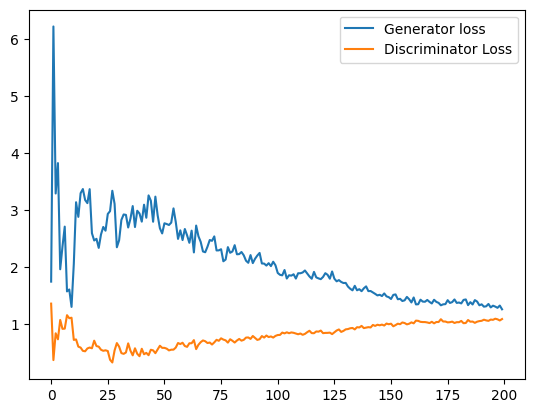

In [13]:
plt.figure()
losses_g = [fl.item() for fl in losses_g]
plt.plot(losses_g, label='Generator loss')
losses_d = [f2.item() for f2 in losses_d]
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()

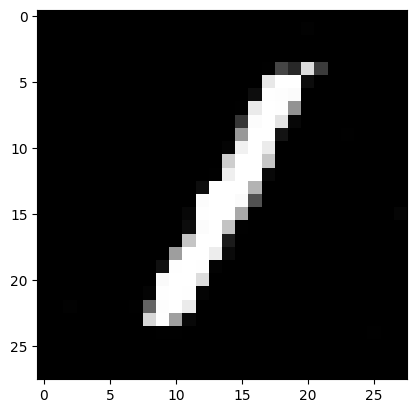

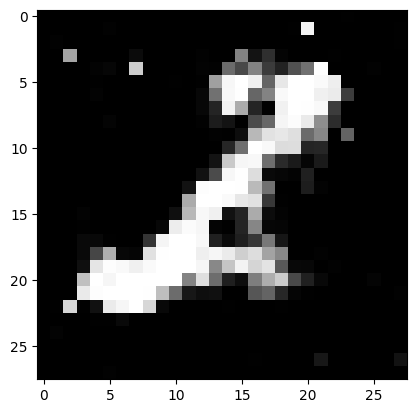

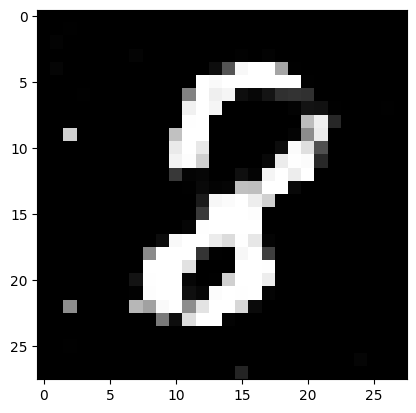

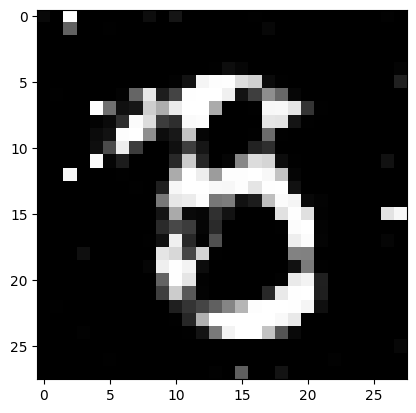

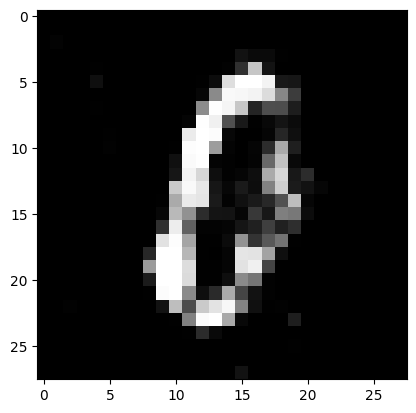

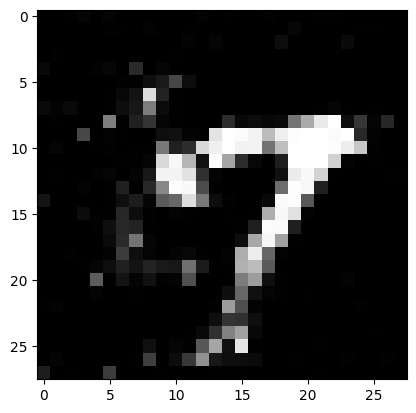

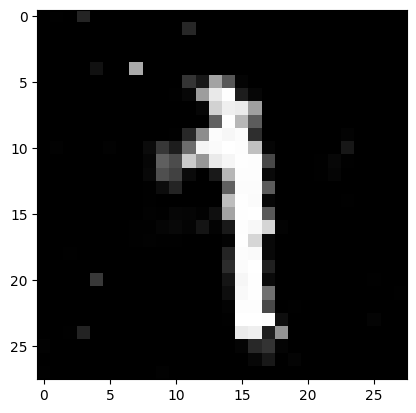

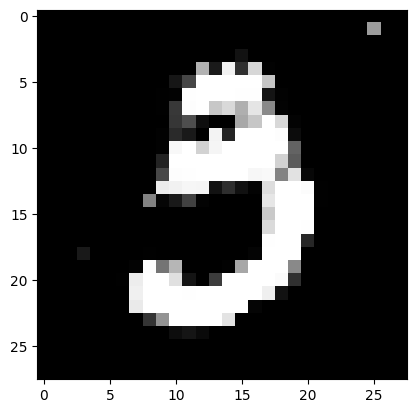

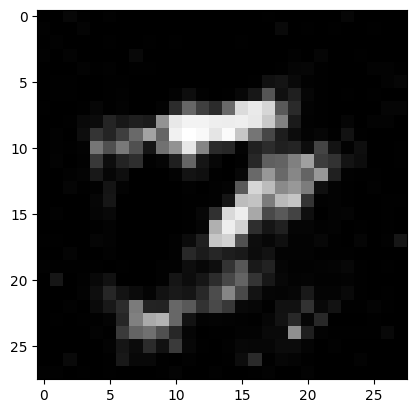

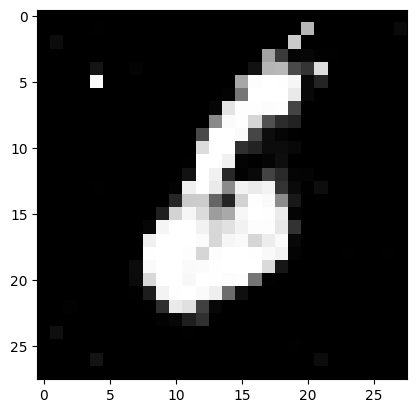

In [14]:
import numpy as np

fake_images = generator(torch.randn(b_size, nz).to(device))
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i], (28, 28))
    plt.imshow(fake_images_img, cmap='gray')
    plt.show()